### Install libraries

In [1]:
# Main
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

pd.set_option('display.max_columns', None)


# Data Prep and Model Evaluation
from sklearn.impute import SimpleImputer as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Algorithms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

### Load data

In [2]:
df = pd.read_csv('data/LoanStats3a.csv', low_memory=False)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,NaN,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648.0,83.70%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62,NaN,Jun-18,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,NaN,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687.0,9.40%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66,NaN,Oct-16,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,NaN,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956.0,98.50%,10.0,f,0.0,0.0,3005.666844,3

In [3]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset")

There are 42542 rows and 145 columns in the dataset


### Clean data

#### Rename columns

In [4]:
# Start with columns to keep
columns_to_keep = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                 'int_rate','installment','grade','sub_grade', \
                 'emp_length','home_ownership','annual_inc', \
                 'verification_status','pymnt_plan','purpose', \
                 'addr_state','dti','delinq_2yrs','earliest_cr_line', \
                 'mths_since_last_delinq','mths_since_last_record', \
                 'open_acc','pub_rec','revol_bal','revol_util', \
                 'total_acc','initial_list_status','out_prncp', \
                 'out_prncp_inv','total_pymnt','total_pymnt_inv', \
                 'total_rec_prncp','total_rec_int','total_rec_late_fee', \
                 'recoveries','collection_recovery_fee','last_pymnt_d', \
                 'last_pymnt_amnt']

#### Keep relevant columns

In [5]:
df = df.loc[:, columns_to_keep] # only keep columns we want and reassign to df

In [6]:
print(f"After dropping the unnecessary columns, there are now {df.shape[0]} rows and {df.shape[1]} columns in the dataset")

After dropping the unnecessary columns, there are now 42542 rows and 37 columns in the dataset


In [7]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,24000.0,Verified,n,credit_card,AZ,27.65,0.0,Jan-85,NaN,NaN,3.0,0.0,13648.0,83.70%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,n,car,GA,1.00,0.0,Apr-99,NaN,NaN,3.0,0.0,1687.0,9.40%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,n,small_business,IL,8.72,0.0,Nov-01,NaN,NaN,2.0,0.0,2956.0,98.50%,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-14,649.91
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,n,other,CA,20.00,0.0,Feb-96,35.0,NaN,10.0,0.0,5598.0,21%,37.0,f,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-15,357.48
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,80000.0,Source Verified,n,other,OR,17.94,0.0,Jan-96,38.0,NaN,15.0,0.0,27783.0,53.90%,38.0,f,0.0,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-17,67.30


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42542 entries, 0 to 42541
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                42535 non-null  float64
 1   funded_amnt              42535 non-null  float64
 2   funded_amnt_inv          42535 non-null  float64
 3   term                     42535 non-null  object 
 4   int_rate                 42535 non-null  object 
 5   installment              42535 non-null  float64
 6   grade                    42535 non-null  object 
 7   sub_grade                42535 non-null  object 
 8   emp_length               41423 non-null  object 
 9   home_ownership           42535 non-null  object 
 10  annual_inc               42531 non-null  float64
 11  verification_status      42535 non-null  object 
 12  pymnt_plan               42535 non-null  object 
 13  purpose                  42535 non-null  object 
 14  addr_state            

#### Convert columns to numeric

In [9]:
# remove all non-numeric characters with a regular expression and chang to dtype float

for i in ["term", "int_rate", "emp_length", "revol_util"]:
    # Convert column to string to ensure .str accessor works
    df[i] = df[i].astype(str)
    
    if i in ["int_rate", "revol_util"]:  # Columns with percentage values
        # Remove "%" and convert to float, divide by 100 to get the decimal representation
        df[i] = df[i].str.replace("%", "").astype(float) / 100.0
    else:
        # For other columns, remove non-numeric characters but keep decimal points if necessary
        # Ensure to convert to string first to avoid AttributeError
        df[i] = df[i].apply(lambda x: re.sub("[^0-9.]", "", x))
    
    # Convert to numeric, errors='coerce' will turn unparseable strings to NaN
    df[i] = pd.to_numeric(df[i], errors='coerce')


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42542 entries, 0 to 42541
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                42535 non-null  float64
 1   funded_amnt              42535 non-null  float64
 2   funded_amnt_inv          42535 non-null  float64
 3   term                     42535 non-null  float64
 4   int_rate                 42535 non-null  float64
 5   installment              42535 non-null  float64
 6   grade                    42535 non-null  object 
 7   sub_grade                42535 non-null  object 
 8   emp_length               41423 non-null  float64
 9   home_ownership           42535 non-null  object 
 10  annual_inc               42531 non-null  float64
 11  verification_status      42535 non-null  object 
 12  pymnt_plan               42535 non-null  object 
 13  purpose                  42535 non-null  object 
 14  addr_state            

#### Impute missing values

In [11]:
# Determine which features are numerical
numericalFeats = [x for x in df.columns if df[x].dtype != 'object']

# Display NaNs by feature
nanCounter = np.isnan(df.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                      7
funded_amnt                    7
funded_amnt_inv                7
term                           7
int_rate                       7
installment                    7
emp_length                  1119
annual_inc                    11
dti                            7
delinq_2yrs                   36
mths_since_last_delinq     26933
mths_since_last_record     38891
open_acc                      36
pub_rec                       36
revol_bal                      7
revol_util                    97
total_acc                     36
out_prncp                      7
out_prncp_inv                  7
total_pymnt                    7
total_pymnt_inv                7
total_rec_prncp                7
total_rec_int                  7
total_rec_late_fee             7
recoveries                     7
collection_recovery_fee        7
last_pymnt_amnt                7
dtype: int64

In [12]:
# Impute NaNs with mean
fill_with_mean = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                'int_rate','installment','emp_length','annual_inc',\
                'dti','open_acc','revol_bal','revol_util','total_acc',\
                'out_prncp','out_prncp_inv','total_pymnt', \
                'total_pymnt_inv','total_rec_prncp','total_rec_int', \
                'last_pymnt_amnt']

# Impute NaNs with zero
fill_with_zero = ['delinq_2yrs','mths_since_last_delinq', \
                'mths_since_last_record','pub_rec','total_rec_late_fee', \
                'recoveries','collection_recovery_fee']

# Perform imputation
im = pp(strategy='mean')
df.loc[:,fill_with_mean] = im.fit_transform(df[fill_with_mean])

df.loc[:,fill_with_zero] = df.loc[:,fill_with_zero].fillna(value=0,axis=1)

In [13]:
# Display NaNs by feature
numericalFeats = [x for x in df.columns if df[x].dtype != 'object'] 

nanCounter = np.isnan(df.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
emp_length                 0
annual_inc                 0
dti                        0
delinq_2yrs                0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
dtype: int64

### Feature Engineering

In [14]:
df['installmentOverLoanAmnt'] = df.installment/df.loan_amnt
df['loanAmntOverIncome'] = df.loan_amnt/df.annual_inc
df['revol_balOverIncome'] = df.revol_bal/df.annual_inc
df['totalPymntOverIncome'] = df.total_pymnt/df.annual_inc
df['totalPymntInvOverIncome'] = df.total_pymnt_inv/df.annual_inc
df['totalRecPrncpOverIncome'] = df.total_rec_prncp/df.annual_inc
df['totalRecIncOverIncome'] = df.total_rec_int/df.annual_inc

new_feats = ['installmentOverLoanAmnt','loanAmntOverIncome', \
            'revol_balOverIncome','totalPymntOverIncome', \
           'totalPymntInvOverIncome','totalRecPrncpOverIncome', \
            'totalRecIncOverIncome']

#### Select final set of features

In [15]:
# Select features for training
numericalPlusNewFeats = numericalFeats+new_feats
X_train = df.loc[:,numericalPlusNewFeats]

# Scale data
scaler = StandardScaler()
X_train.loc[:,:] = scaler.fit_transform(X_train)

### Label Encoding

In [16]:
labels = df.grade
labels.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G', nan], dtype=object)

In [17]:
labels = labels.fillna(value="Z")

In [18]:
# Convert labels to numerical values
lbl = LabelEncoder()
lbl.fit(list(labels.values)) # Fit label encoder with our list of grades


LabelEncoder()

In [19]:
# Transform labels to numerical values

labels = pd.Series(data=lbl.transform(labels.values), name="grade")


In [20]:
# Store as y training data
y_train = labels

In [21]:
# Concatenate labels to features for later use 

labelsOriginalVSNew = pd.concat([labels, df.grade],axis=1) 

labelsOriginalVSNew

,grade,grade
0,1,B
1,2,C
2,2,C
3,2,C
4,1,B
...,...,...
42537,0,A
42538,7,NaN
42539,7,NaN
42540,7,NaN


In [22]:
# Compare loan grades with interest rates
interestAndGrade = pd.DataFrame(data=[df.int_rate,labels])
interestAndGrade = interestAndGrade.T

interestAndGrade.groupby("grade").mean()

,int_rate
grade,
0.0,0.073427
1.0,0.110142
2.0,0.134999
3.0,0.155771
4.0,0.173768
5.0,0.192653
6.0,0.204512
7.0,0.121650


### Analyzing the Goodness of Clusters

"The higher the percentage of borrowers that have the most frequently occurring numerical loan grade in each and every cluster, the better the clustering application."

"As an example, consider a cluster with one hundred borrowers. If 30 borrowers have a numerical loan grade of 0, 25 borrowers have a loan grade of 1, 20 borrowers have a loan grade of 2, and the remaining borrowers have loan grades ranging from 3 to 7, we would say that the cluster has a 30% accuracy, given that the most frequently occuring loan grade for that cluster applies to just 30% of the borrowers in that cluster."

### PCA

In [26]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,installmentOverLoanAmnt,loanAmntOverIncome,revol_balOverIncome,totalPymntOverIncome,totalPymntInvOverIncome,totalRecPrncpOverIncome,totalRecIncOverIncome
0,5000.0,5000.0,4975.0,36.0,0.1065,162.87,B,B2,10.0,RENT,24000.0,Verified,n,credit_card,AZ,27.65,0.0,Jan-85,0.0,0.0,3.0,0.0,13648.0,0.837,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62,0.032574,0.208333,0.568667,0.244298,0.243077,0.208333,0.035965
1,2500.0,2500.0,2500.0,60.0,0.1527,59.83,C,C4,1.0,RENT,30000.0,Source Verified,n,car,GA,1.00,0.0,Apr-99,0.0,0.0,3.0,0.0,1687.0,0.094,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66,0.023932,0.083333,0.056233,0.033818,0.033818,0.015215,0.014506
2,2400.0,2400.0,2400.0,36.0,0.1596,84.33,C,C5,10.0,RENT,12252.0,Not Verified,n,small_business,IL,8.72,0.0,Nov-01,0.0,0.0,2.0,0.0,2956.0,0.985,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-14,649.91,0.035138,0.195886,0.241267,0.245321,0.245321,0.195886,0.049434
3,10000.0,10000.0,10000.0,36.0,0.1349,339.31,C,C1,10.0,RENT,49200.0,Source Verified,n,other,CA,20.00,0.0,Feb-96,35.0,0.0,10.0,0.0,5598.0,0.210,37.0,f,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-15,357.48,0.033931,0.203252,0.113780,0.248616,0.248616,0.203252,0.045019
4,3000.0,3000.0,3000.0,60.0,0.1269,67.79,B,B5,1.0,RENT,80000.0,Source Verified,n,other,OR,17.94,0.0,Jan-96,38.0,0.0,15.0,0.0,27783.0,0.539,38.0,f,0.0,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-17,67.30,0.022597,0.037500,0.347288,0.050836,0.050836,0.037500,0.013336


In [27]:
# Create a dataframe for PCA
pca_df = df.loc[:,numericalPlusNewFeats]

In [28]:
pca_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,installmentOverLoanAmnt,loanAmntOverIncome,revol_balOverIncome,totalPymntOverIncome,totalPymntInvOverIncome,totalRecPrncpOverIncome,totalRecIncOverIncome
0,5000.0,5000.0,4975.0,36.0,0.1065,162.87,10.0,24000.0,27.65,0.0,0.0,0.0,3.0,0.0,13648.0,0.837,9.0,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,171.62,0.032574,0.208333,0.568667,0.244298,0.243077,0.208333,0.035965
1,2500.0,2500.0,2500.0,60.0,0.1527,59.83,1.0,30000.0,1.00,0.0,0.0,0.0,3.0,0.0,1687.0,0.094,4.0,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,119.66,0.023932,0.083333,0.056233,0.033818,0.033818,0.015215,0.014506
2,2400.0,2400.0,2400.0,36.0,0.1596,84.33,10.0,12252.0,8.72,0.0,0.0,0.0,2.0,0.0,2956.0,0.985,10.0,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,649.91,0.035138,0.195886,0.241267,0.245321,0.245321,0.195886,0.049434
3,10000.0,10000.0,10000.0,36.0,0.1349,339.31,10.0,49200.0,20.00,0.0,35.0,0.0,10.0,0.0,5598.0,0.210,37.0,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,357.48,0.033931,0.203252,0.113780,0.248616,0.248616,0.203252,0.045019
4,3000.0,3000.0,3000.0,60.0,0.1269,67.79,1.0,80000.0,17.94,0.0,38.0,0.0,15.0,0.0,27783.0,0.539,38.0,0.0,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,67.30,0.022597,0.037500,0.347288,0.050836,0.050836,0.037500,0.013336


In [29]:
# Encode the categorical data
pca_df = pd.get_dummies(pca_df)

pca_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,installmentOverLoanAmnt,loanAmntOverIncome,revol_balOverIncome,totalPymntOverIncome,totalPymntInvOverIncome,totalRecPrncpOverIncome,totalRecIncOverIncome
0,5000.0,5000.0,4975.0,36.0,0.1065,162.87,10.0,24000.0,27.65,0.0,0.0,0.0,3.0,0.0,13648.0,0.837,9.0,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,171.62,0.032574,0.208333,0.568667,0.244298,0.243077,0.208333,0.035965
1,2500.0,2500.0,2500.0,60.0,0.1527,59.83,1.0,30000.0,1.00,0.0,0.0,0.0,3.0,0.0,1687.0,0.094,4.0,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,119.66,0.023932,0.083333,0.056233,0.033818,0.033818,0.015215,0.014506
2,2400.0,2400.0,2400.0,36.0,0.1596,84.33,10.0,12252.0,8.72,0.0,0.0,0.0,2.0,0.0,2956.0,0.985,10.0,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,649.91,0.035138,0.195886,0.241267,0.245321,0.245321,0.195886,0.049434
3,10000.0,10000.0,10000.0,36.0,0.1349,339.31,10.0,49200.0,20.00,0.0,35.0,0.0,10.0,0.0,5598.0,0.210,37.0,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,357.48,0.033931,0.203252,0.113780,0.248616,0.248616,0.203252,0.045019
4,3000.0,3000.0,3000.0,60.0,0.1269,67.79,1.0,80000.0,17.94,0.0,38.0,0.0,15.0,0.0,27783.0,0.539,38.0,0.0,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,67.30,0.022597,0.037500,0.347288,0.050836,0.050836,0.037500,0.013336


In [30]:
# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_df)

In [31]:
# PCA
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(scaled_data)
print(f"Reduced to {pca.n_components_} dimensions.")

Reduced to 17 dimensions.


In [40]:
# Show final 17 features
pca_df = pd.DataFrame(data=pca_data)
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-1.375064,-1.445166,0.925634,2.775972,-0.014935,0.488754,-0.288977,1.017299,-0.310776,-0.319285,1.540079,-0.070924,-1.548991,0.047141,1.224338,-0.062316,0.224005
1,-3.807166,-1.516529,0.516436,-2.047790,1.258832,-1.934036,-1.008211,1.515121,0.418918,-0.039208,-0.816065,-0.074777,0.924094,-0.543860,-0.959821,-0.369207,0.859961
2,-2.174482,-2.360068,0.955121,0.998395,0.117844,0.723825,-1.480739,0.546351,-0.430617,-0.442767,1.759183,0.051548,-1.137999,0.920184,-1.160115,0.474393,-0.329296
3,0.259727,0.032964,-0.161673,0.354099,-0.086115,0.270610,0.696112,-2.039454,-0.080509,2.018742,1.203531,-0.438119,-0.948744,0.231217,0.199699,-0.106486,0.647365
4,-2.766662,1.646717,1.570135,0.761362,0.401817,-2.777737,0.223173,-0.559259,-0.654205,0.285299,-1.346792,-0.118083,1.163550,0.127299,0.251398,-0.208719,-0.440539


/opt/homebrew/Caskroom/miniforge/base/envs/cx-analytics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cx-analytics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cx-analytics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cx-analytics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will cha

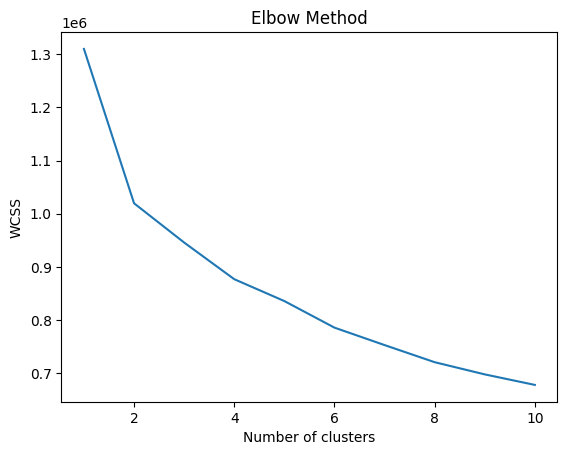

In [32]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

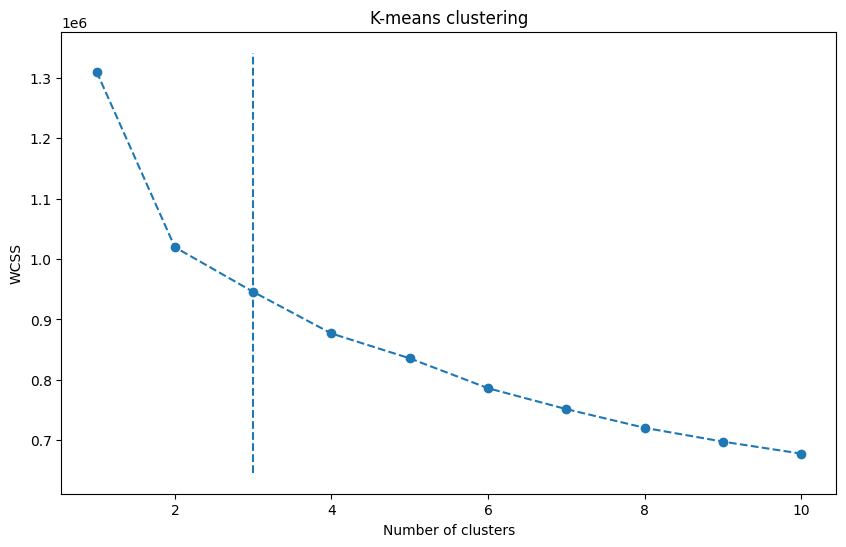

In [34]:
# determin the number of K
from kneed import KneeLocator
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)

k1 = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
optimized_k = k1.elbow

# visualize the result
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.vlines(optimized_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means clustering')
plt.show()

In [35]:
kmeans = KMeans(n_clusters=optimized_k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_data)

/opt/homebrew/Caskroom/miniforge/base/envs/cx-analytics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [36]:
pca_df['Cluster'] = cluster_labels

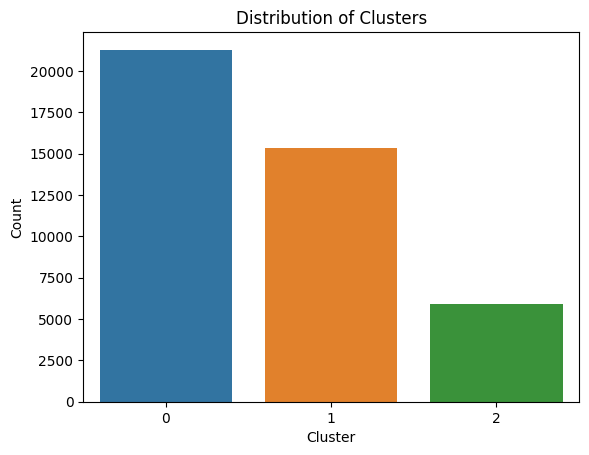

In [38]:
sns.countplot(x='Cluster', data=pca_df)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [ ]:
sns.boxplot(x='Cluster', y='feature_name', data=df)  # Replace 'feature_name' with your column name
plt.title('Feature Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Feature Value')
plt.show()

#### K-Means

In [ ]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = \
        pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']

    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']

    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())

    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg( \
        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']

    accuracyDF = countMostFreq.merge(countByCluster, \
        left_on="cluster",right_on="cluster")
    
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
        accuracyDF.clusterCount.sum()

    accuracyByLabel = accuracyDF.countMostFrequent/ \
        accuracyDF.clusterCount

    return countByCluster, countByLabel, countMostFreq, \
        accuracyDF, overallAccuracy, accuracyByLabel

In [ ]:
n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
#n_jobs = 2 (deprecated)

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, \
                random_state=random_state)

kMeans_inertia = pd.DataFrame(data=[],index=range(10,31), \
                              columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[], \
    index=range(10,31),columns=['overallAccuracy'])

for n_clusters in range(10,31):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                    max_iter=max_iter, tol=tol, \
                    random_state=random_state)
    
    kmeans.fit(X_train)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train)
    X_train_kmeansClustered = pd.DataFrame(data= \
        X_train_kmeansClustered, index=X_train.index, \
        columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, \
    countMostFreq_kMeans, accuracyDF_kMeans, \
    overallAccuracy_kMeans, accuracyByLabel_kMeans = \
    analyzeCluster(X_train_kmeansClustered, y_train)

    overallAccuracy_kMeansDF.loc[n_clusters] = \
        overallAccuracy_kMeans
    
overallAccuracy_kMeansDF.plot()

In [ ]:
# Print the accuracy by cluster for k = 30
accuracyByLabel_kMeans # Accuracy by cluster
